In [1]:
import numpy as np
import pandas as pd
import json
import glob
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore')

c:\users\krister\climdist\gensim_env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_excel('../data/processed/LNB_processed.xlsx')

In [3]:
stops = stopwords.words('german')
common_ocr_errors = ['nnr', 'nnd', 'fich', 'find']
other_noise = ['januar', 'februar', 'märz', 'april', 'mai', 'juni', 'juli', 'august', 'september', 'october', 'oktober', 'november', 'dezember', 'december']
stops += common_ocr_errors + other_noise

In [4]:
data = df[(df.w_count > 100) & (df.w_count < 500)].sample(1000).full_text.values

In [5]:
nlp = spacy.load('../data/models/spacy_model_250421')

In [6]:
def lemmatize(texts, allowed_postags=['NOUN']):
    
    texts_out = []
    
    for text in tqdm(texts):
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token.text.lower() not in stops:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    
    return texts_out

lemmatized_data = lemmatize(data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:32<00:00,  6.56it/s]


In [7]:
len(lemmatized_data)

1000

In [8]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True) #separates words, applies lowercase, removes accents
        final.append(new)
    return final

data_words = gen_words(lemmatized_data)

In [89]:
# bigrams, trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=2)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=10)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

data_bigrams = [bigram[doc] for doc in data_words]
data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_words]

In [77]:
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)
id2word.filter_extremes(no_above=0.3)
corpus = [id2word.doc2bow(text) for text in data_bigrams_trigrams]
tfidf = TfidfModel(corpus, id2word=id2word)

In [94]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_bigrams_trigrams, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.37896305091332766


In [99]:
def get_optimal_n_topics(texts, no_above, start, end, step, alpha='auto'):
    
    from gensim.models import TfidfModel

    id2word = corpora.Dictionary(texts)
    id2word.filter_extremes(no_above=no_above)
    corpus = [id2word.doc2bow(text) for text in texts]
    tfidf = TfidfModel(corpus, id2word=id2word)
    
    n_topics = []
    coherence_scores = []
    
    for n in range(start, end+1, step):
        print(f'Computing model with {n} topics')
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha=alpha)
        
        coherence_model = gensim.models.CoherenceModel(model=model, texts=data_bigrams_trigrams, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        print('Coherence Score: ', coherence_score)
        
        n_topics.append(n)
        coherence_scores.append(coherence_score)
        
    from matplotlib import pyplot as plt
    plt.plot(range(start, end+1, step), coherence_scores)
    plt.show()
    
    print(f'Optimal number of topics: {n_topics[coherence_scores.index(max(coherence_scores))]}')
        
    return (n_topics, coherence_scores)

Computing model with 1 topics
Coherence Score:  0.15537474315525454
Computing model with 5 topics
Coherence Score:  0.2687950621174609
Computing model with 9 topics
Coherence Score:  0.3240587196210457
Computing model with 13 topics
Coherence Score:  0.3710892421622931
Computing model with 17 topics
Coherence Score:  0.3589028866289064
Computing model with 21 topics
Coherence Score:  0.3634415940654123
Computing model with 25 topics
Coherence Score:  0.3542740606071179
Computing model with 29 topics
Coherence Score:  0.37602991555665005
Computing model with 33 topics
Coherence Score:  0.3797733102982181
Computing model with 37 topics
Coherence Score:  0.38188059000524727


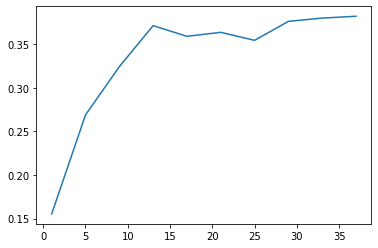

Optimal number of topics: 37


In [98]:
optimal_n_topics_no_above_01 = get_optimal_n_topics(data_bigrams_trigrams, no_above=0.1, start=1, end=40, step=4)

In [53]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=7,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds', R=30)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.106267 -0.297040       1        1  19.719988
6      0.058035  0.365215       2        1  18.332635
3     -0.160645 -0.291171       3        1  17.502695
0     -0.234214  0.231452       4        1  16.484546
5      0.276061  0.168887       5        1  14.213252
2      0.328136 -0.129238       6        1   9.499705
1     -0.373640 -0.048105       7        1   4.247179, topic_info=          Term        Freq       Total Category  logprob  loglift
261     wasser  214.000000  214.000000  Default  30.0000  30.0000
92      schiff  200.000000  200.000000  Default  29.0000  29.0000
328      stadt  429.000000  429.000000  Default  28.0000  28.0000
176       herr  245.000000  245.000000  Default  27.0000  27.0000
762      herrn  197.000000  197.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
564       werk   21.135884   63.370780   Topic7  -4.4452   2.0609
262      woche   20.473138   84.807653   Topic7  -4.4771   1.7376
126      preis   19.911130   92.540580   Topic7  -4.5049   1.6225
1434  wahrheit   13.658609   27.439635   Topic7  -4.8818   2.4613
19        jahr   15.768245  382.843992   Topic7  -4.7382  -0.0307

[382 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
541       2  0.033676     abend
541       3  0.797001     abend
541       6  0.168380     abend
658       1  0.972196    abends
0         6  0.980826  abschluß
...     ...       ...       ...
707       4  0.276082       ztg
334       1  0.989616       zug
335       1  0.964974   zukunft
264       5  0.922057     zweck
264       6  0.075578     zweck

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 4, 1, 6, 3, 2])

### Notes from first bigrams_trigrams LDA vis:

1. add common OCR errors to stopwords: nnd, fich, find, nnr
2. add "noisewords" ubiquitous in newspapers, like 'tag', 'uhr'

In [267]:
#readable_corpus = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]

In [ ]:
# alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

In [158]:
def remove_hi_tf_words(corpus, treshold):
    
    corpus_wordcount = 0
    for text in corpus:
        corpus_wordcount += len(text)
    print(corpus_wordcount)
    
    frequencies = {}
    for text in corpus:
        for token in text:
            if token in frequencies.keys():
                frequencies[token] += 1
            else:
                frequencies[token] = 1
            
    print(len(frequencies))
    print(max(frequencies.values()))
            
    new_corpus = []
    
    for text in corpus:
        new_text = []
        for token in text:
            if frequencies[token]/corpus_wordcount > treshold:
                print(frequencies[token])
                new_text.append(token)
        new_corpus.append(new_text)
                
    return new_corpus